## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import ArrayLike
from tqdm.notebook import tqdm

## Distributions

In [ ]:
def make_circles(n_samples : int = 100,
                 shuffle : bool = True,
                 noise : float = None,
                 random_state : int = None,
                 factor : float = 0.8):

    rng = np.random.default_rng(seed = random_state)

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    linspace_out = np.linspace(0, 2 * np.pi, n_samples_out, endpoint = False)
    linspace_in = np.linspace(0, 2 * np.pi, n_samples_in, endpoint = False)

    X1_out = np.cos(linspace_out) * 5
    X2_out = np.sin(linspace_out) * 5

    X1_in = np.cos(linspace_in) * 5 * factor
    X2_in = np.sin(linspace_in) * 5 * factor

    X = np.vstack(
        [np.append(X1_out, X1_in), np.append(X2_out, X2_in)]
    ).T

    y = np.hstack (
        [np.zeros(n_samples_out, dtype = int), np.ones(n_samples_in, dtype = int)]
    )

    if noise is not None:
        X += rng.normal(scale = noise, size = X.shape)

    if shuffle:
        permutation = rng.permutation(n_samples)
        X = X[permutation]
        y = y[permutation]

    return X, y


def make_xor(n_samples : int = 100,
             noise : float = 0.2,
             scale : float = 1.0,
             centers : ArrayLike | None = None,
             shuffle : bool = True,
             random_state : int = 42,
             return_centers : bool = False):

    rng = np.random.default_rng(seed = random_state)

    if centers is None:
        centers = np.array(
            [
                (scale, scale),
                (scale, -scale),
                (-scale, scale),
                (-scale, -scale),
             ],
            dtype = float
            )

    n_centers = centers.shape[0]

    base = n_samples // n_centers
    extra = n_samples % n_centers

    clusters = np.zeros(n_centers, dtype = int)

    for k in range(n_centers):
        if k < extra:
            clusters[k] = base + 1
        else:
            clusters[k] = base

    X = np.empty((n_samples, 2))
    y = np.empty(n_samples, dtype = int)

    pos = 0
    for k in range(n_centers):
        normal_matrix = rng.normal(loc = 0, scale = 1, size = (clusters[k], 2))
        X_k = centers[k] + noise * normal_matrix

        if k in [0, 3]:
            y[pos : pos + clusters[k]] = 0
        else:
            y[pos : pos + clusters[k]] = 1

        X[pos : pos + clusters[k]] = X_k
        pos += clusters[k]

    if shuffle:
        permutation = rng.permutation(n_samples)
        X = X[permutation]
        y = y[permutation]

    if return_centers:
        return X, y, centers
    return X, y


def make_blobs(n_samples : int = 100,
               n_features : int = 2,
               centers : int | ArrayLike | None = None,
               cluster_std : float | ArrayLike = 1.0,
               center_box : tuple[float, float] = (-1.0, 1.0),
               shuffle : bool = True,
               random_state : int = 42,
               return_centers : bool = False):

    rng = np.random.default_rng(seed = random_state)

    if centers is None:
        n_centers = 2

        centers = rng.uniform(
            center_box[0], center_box[1], size = (n_centers, n_features)
        )

    elif isinstance(centers, int):
        n_centers = centers
        centers = rng.uniform(
            center_box[0], center_box[1], size = (n_centers, n_features)
        )

    else:
        centers = np.asarray(centers, dtype = float)
        n_centers = centers.shape[0]

    base = n_samples // n_centers
    extra = n_samples % n_centers

    clusters = np.zeros(n_centers, dtype = int)

    for k in range(n_centers):
        if k < extra:
            clusters[k] = base + 1
        else:
            clusters[k] = base

    if isinstance(cluster_std, int | float):
        cluster_std_sigma = cluster_std
        cluster_std = np.repeat(cluster_std_sigma, n_centers)

    X = np.empty((n_samples, n_features))
    y = np.empty(n_samples, dtype = int)

    pos = 0

    for k in range(n_centers):
        normal_matrix = rng.normal(loc = 0, scale = 1, size = (clusters[k], n_features))
        X_k = centers[k] + cluster_std[k] * normal_matrix

        y[pos : pos + clusters[k]] = k
        X[pos : pos + clusters[k]] = X_k
        pos += clusters[k]

    if shuffle:
        permutation = rng.permutation(n_samples)
        X = X[permutation]
        y = y[permutation]

    if return_centers:
        return X, y, centers

    return X, y


def make_spiral(n_samples : int = 100,
                turns : int = 2,
                radius : float = 0.0,
                sweep : float = 0.15,
                shuffle : bool = True,
                noise : float = None,
                random_state : int = 42):

    rng = np.random.default_rng(seed = random_state)

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    theta_out = np.linspace(0, turns * 2 * np.pi, n_samples_out, endpoint = False)
    theta_in = np.linspace(0, turns * 2 * np.pi, n_samples_in, endpoint = False)

    spiral_out = radius + sweep * theta_out
    spiral_in = radius + sweep * theta_in

    X1_out = spiral_out * np.cos(theta_out)
    X2_out = spiral_out * np.sin(theta_out)

    X1_in = spiral_in * np.cos(theta_in + np.pi)
    X2_in = spiral_in * np.sin(theta_in + np.pi)

    X = np.vstack(
        [np.append(X1_out, X1_in), np.append(X2_out, X2_in)]
    ).T

    y = np.hstack(
        [np.zeros(n_samples_out, dtype = int), np.ones(n_samples_in, dtype = int)]
    )

    if noise is not None:
        X += rng.normal(scale = noise, size = X.shape)

    if shuffle:
        permutation = rng.permutation(n_samples)
        X = X[permutation]
        y = y[permutation]

    return X, y

## Perceptron

In [ ]:
class Perceptron:
    def __init__(self, activation_function : str = 'step', fit_intercept : bool = True):

        assert activation_function in ['step', 'sigmoid']
        self.activation_function = activation_function
        self.fit_intercept = fit_intercept

        self.weights = None

    def _add_bias(self, X : np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            return np.hstack([np.ones((X.shape[0], 1)), X])
        return X

    def decision_function(self, X : np.ndarray) -> np.ndarray:
        Xb = self._add_bias(X)
        return Xb @ self.weights

    def predict_proba(self, X : np.ndarray) -> np.ndarray:
        if self.activation_function != 'sigmoid':
            raise ValueError("predict_proba method available only for sigmoid function!")
        z = np.clip(self.decision_function(X), -50, 50)
        return 1 / (1 + np.exp(-z))

    def predict(self, X : np.ndarray) -> np.ndarray:
        if self.activation_function == 'step':
            return (self.decision_function(X) >= 0).astype(int)
        else:
            return (self.predict_proba(X) >= 0.5).astype(int)

    def fit(self, X: np.ndarray,
            y: np.ndarray,
            random_state : int = 42,
            learning_rate : float = 0.01,
            n_epochs : int = 100,
            ):

        X = np.asarray(X, dtype = float)
        y = np.asarray(y, dtype = int).ravel()

        rng = np.random.default_rng(seed = random_state)

        Xb = self._add_bias(X)
        n_features = Xb.shape[1]

        self.weights = np.zeros(n_features, dtype = float)

        if self.activation_function == 'step':
            Xb_base = Xb.copy()
            y_norm_base = 2 * y - 1

            for epoch in tqdm(
                range(n_epochs),
                desc = "Fitting perceptron",
                unit = "epoch",
                total = n_epochs,
                dynamic_ncols = True,
                leave = True,
                mininterval = 0.1):

                updates_epoch = 0

                permutation = rng.permutation(X.shape[0])
                Xb = Xb_base[permutation]
                y_norm = y_norm_base[permutation]

                for i in range(Xb.shape[0]):
                    if y_norm[i] * (Xb[i] @ self.weights) <= 0:
                        self.weights += learning_rate * y_norm[i] * Xb[i]
                        updates_epoch += 1

                if updates_epoch == 0:
                    break

        else:
            for epoch in tqdm(
                range(n_epochs),
                desc = "Fitting perceptron",
                unit = "epoch",
                total = n_epochs,
                dynamic_ncols = True,
                leave = True,
                mininterval = 0.1):

                z = np.clip(Xb @ self.weights, -50, 50)
                p = 1 / (1 + np.exp(-z))
                grad = (Xb.T @ (p - y)) / Xb.shape[0]
                self.weights -= learning_rate * grad

        return self

In [ ]:
def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> np.array:
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    true_negative = np.sum((y_true == 0) & (y_pred == 0))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))

    return np.array([[true_negative, false_positive],
                     [false_negative, true_positive]], dtype=int)


def classification_report(y_true : np.ndarray, y_pred : np.ndarray):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    true_negative = np.sum((y_true == 0) & (y_pred == 0))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))

    assert true_positive + false_positive > 0
    assert true_positive + false_negative > 0

    accuracy = (true_positive + true_negative) / y_true.shape[0]
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = 2 * precision * recall / (precision + recall)

    return {
        'Accuracy' : accuracy,
        'Precision' : precision,
        'Recall' : recall,
        'F1-score' : f1_score
        }

def draw_distribution(X : np.ndarray, y : np.ndarray, title : str | None = None) -> np.ndarray:
    plt.figure(figsize=(8, 6))

    X_neg = X[y == 0]
    X_pos = X[y == 1]

    plt.xlim((-6, 6))
    plt.ylim((-6, 6))
    plt.scatter(X_neg[:, 0], X_neg[:, 1], color = '#f19b35')
    plt.scatter(X_pos[:, 0], X_pos[:, 1], color = '#2082c0')
    plt.grid(True)
    plt.xlabel('X1')
    plt.ylabel('X2')

def split_data(X: np.array, y: np.array, ratio: float = 0.30, random_state: int = 42):
    rng = np.random.default_rng(seed=random_state)
    idx = np.arange(X.shape[0])
    rng.shuffle(idx)
    left_share = int((1 - ratio) * X.shape[0])

    train_idx = idx[:left_share]
    test_idx  = idx[left_share:]

    return train_idx, test_idx

## Distributions visualization

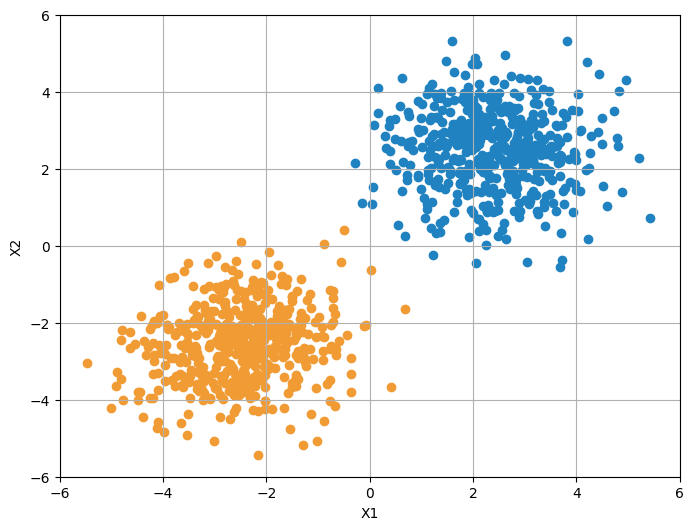

In [ ]:
X, y = make_blobs(n_samples = 1000, centers = [-2.5, 2.5], cluster_std = 1.0)

draw_distribution(X, y)

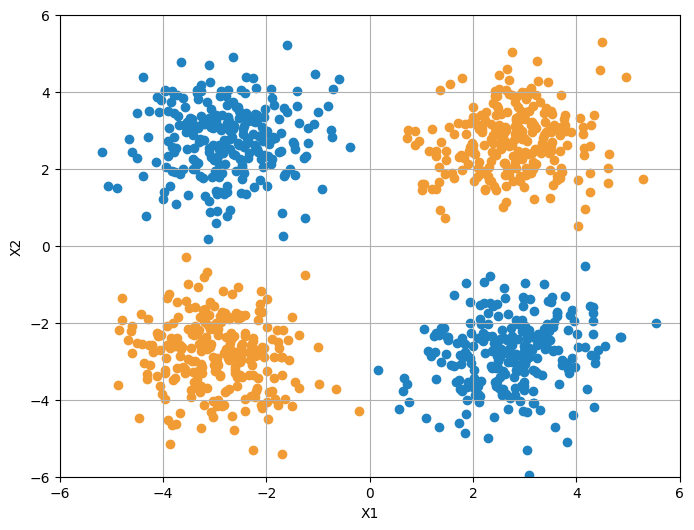

In [ ]:
X, y = make_xor(n_samples = 1000, scale = 2.75, noise = 0.875)

draw_distribution(X, y)

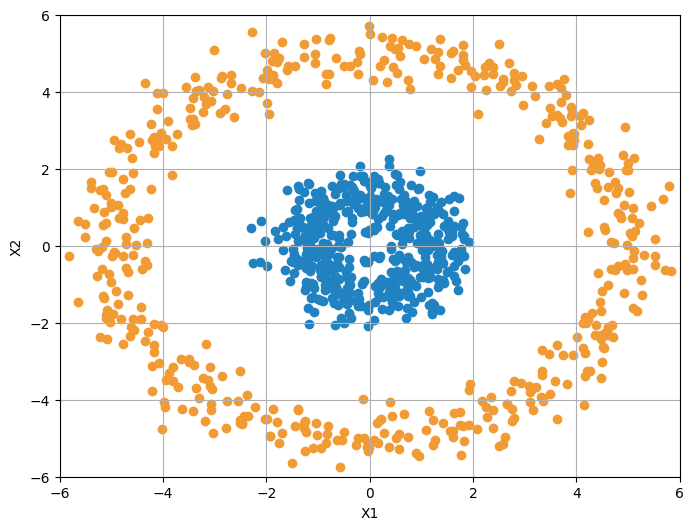

In [ ]:
X, y = make_circles(n_samples = 1000, noise = 0.4, factor = 0.25, random_state = 52)

draw_distribution(X, y)

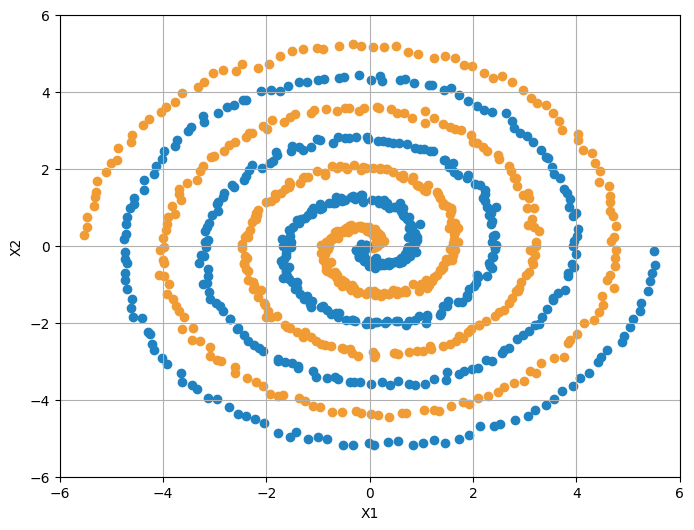

In [ ]:
X, y = make_spiral(n_samples = 1000, sweep = 0.25, turns = 3.5, noise = 0.05, radius = 0.05)
draw_distribution(X, y)

## Step function

### Cirecles fitting part

In [ ]:
X, y = make_circles(n_samples = 1000, noise = 0.4, factor = 0.25, random_state = 52)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'step', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

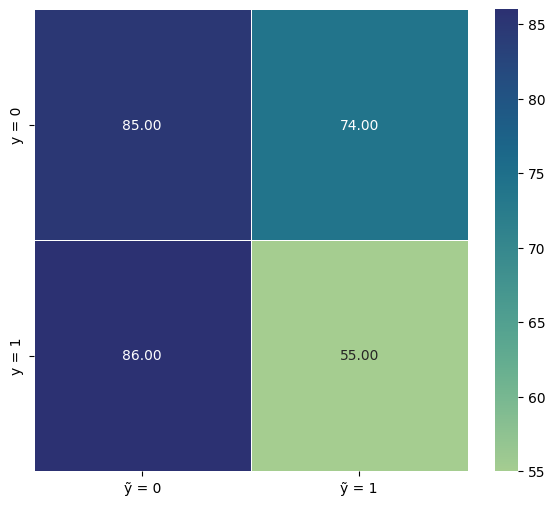

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
step_report = []
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
step_report.append(classification_report(y_test, y_pred))

### XOR fitting part

In [ ]:
X, y = make_xor(n_samples = 1000, scale = 2.75, noise = 0.875)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'step', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

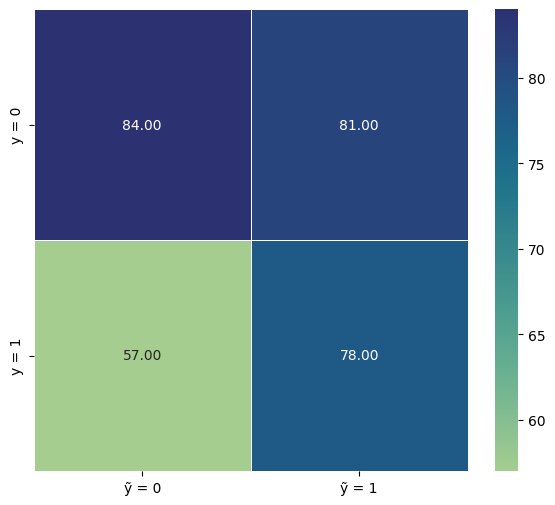

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
step_report.append(classification_report(y_test, y_pred))

### Blobs fitting part

In [ ]:
X, y = make_blobs(n_samples = 1000, centers = [-2.5, 2.5], cluster_std = 1.0)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'step', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

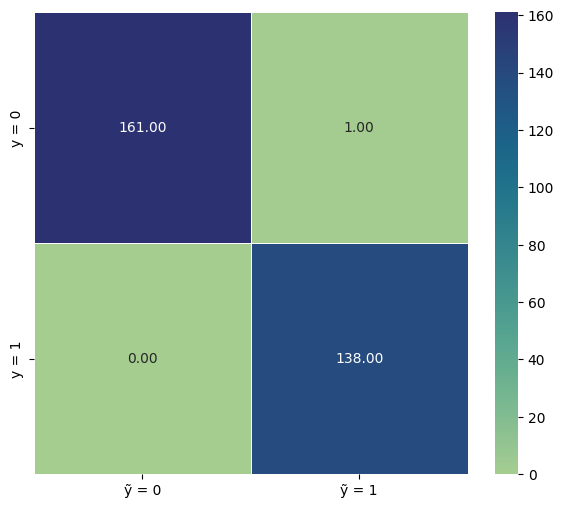

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
step_report.append(classification_report(y_test, y_pred))

### Spirals fitting part

In [ ]:
X, y = make_spiral(n_samples = 1000, sweep = 0.25, turns = 3.5, noise = 0.05, radius = 0.05)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'step', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

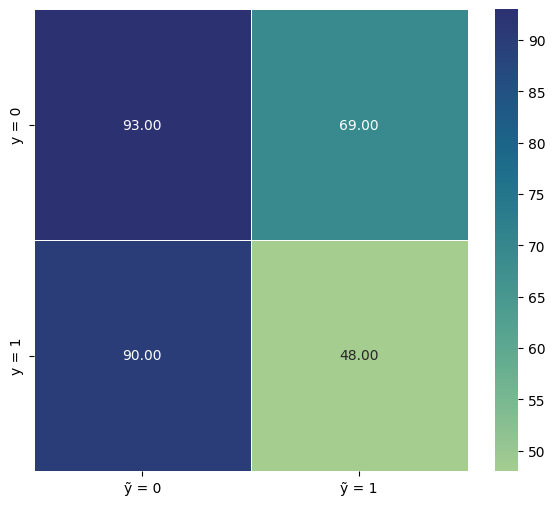

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
step_report.append(classification_report(y_test, y_pred))

In [ ]:
pd.DataFrame(step_report, index = ['spirals', 'XOR', 'Blobs', 'Spirals'])

,Accuracy,Precision,Recall,F1-score
spirals,0.466667,0.426357,0.390071,0.407407
XOR,0.540000,0.490566,0.577778,0.530612
Blobs,0.996667,0.992806,1.000000,0.996390
Spirals,0.470000,0.410256,0.347826,0.376471


## Sigmoid function

### Cirecles fitting part

In [ ]:
X, y = make_circles(n_samples = 1000, noise = 0.4, factor = 0.25, random_state = 52)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'sigmoid', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

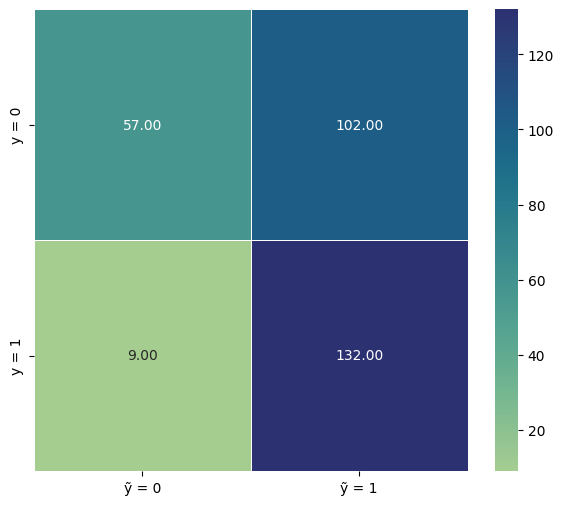

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
sigmoid_report = []
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
sigmoid_report.append(classification_report(y_test, y_pred))

### XOR fitting part

In [ ]:
X, y = make_xor(n_samples = 1000, scale = 2.75, noise = 0.875)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'sigmoid', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

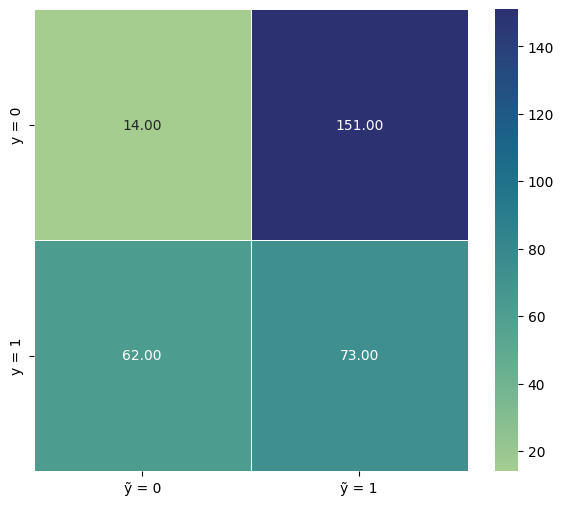

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
sigmoid_report.append(classification_report(y_test, y_pred))

### Blobs fitting part

In [ ]:
X, y = make_blobs(n_samples = 1000, centers = [-2.5, 2.5], cluster_std = 1.0)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'sigmoid', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

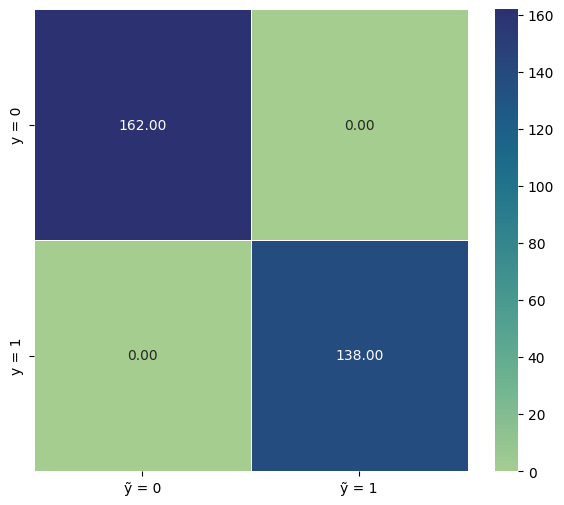

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
sigmoid_report.append(classification_report(y_test, y_pred))

### Spirals fitting part

In [ ]:
X, y = make_spiral(n_samples = 1000, sweep = 0.25, turns = 3.5, noise = 0.05, radius = 0.05)
train_idx, test_idx = split_data(X, y, ratio = 0.3, random_state = 52)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

elementary_perceptron = Perceptron(activation_function = 'sigmoid', fit_intercept = True)
elementary_perceptron.fit(X_train, y_train, random_state = 52, learning_rate = 0.03, n_epochs = 1000)

Fitting perceptron:   0%|          | 0/1000 [00:00<?, ?epoch/s]

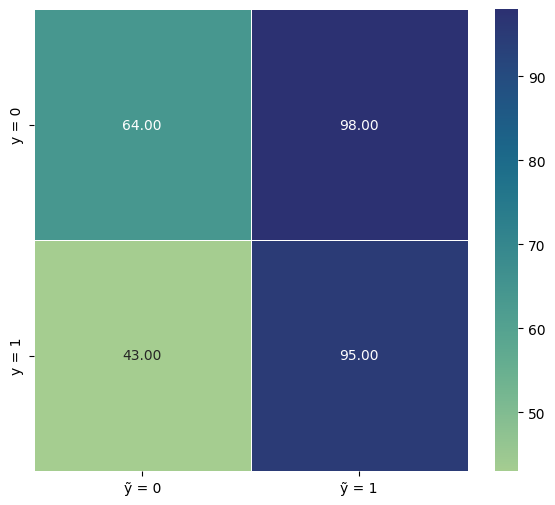

In [ ]:
y_pred = elementary_perceptron.predict(X_test)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       index = ['y = 0', 'y = 1'],
                       columns = ['ỹ = 0', 'ỹ = 1'])
plt.figure(figsize = (7, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt=".2f", linewidths=.5)
plt.show()
sigmoid_report.append(classification_report(y_test, y_pred))

In [ ]:
pd.DataFrame(sigmoid_report, index = ['spirals', 'XOR', 'Blobs', 'Spirals'])

,Accuracy,Precision,Recall,F1-score
spirals,0.63,0.564103,0.936170,0.704000
XOR,0.29,0.325893,0.540741,0.406685
Blobs,1.00,1.000000,1.000000,1.000000
Spirals,0.53,0.492228,0.688406,0.574018
